# Trabajo Práctico 5

Utilizando la webcam
1. Implementar un algoritmo de seguimiento con CamShift que:
    
    a. Permita elegir la ROI del objeto a seguir
    
    b. Permita cambiar la escala de la ventana (no necesariamente la orientación)

In [35]:
# Importamos las librerías necesarias
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [36]:
camera = cv.VideoCapture(0)

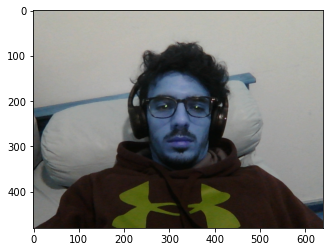

In [37]:
ret,frame = camera.read()
plt.figure()
plt.imshow(frame)

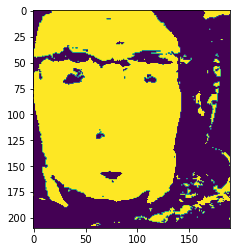

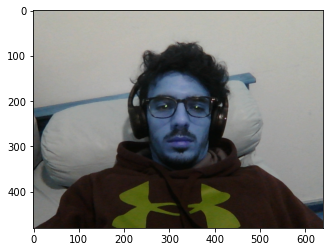

In [38]:
X1=250
Xdelta=190
Y1=150
Ydelta=210
track_window=(X1,Y1,Xdelta,Ydelta)
roi=frame[Y1:Y1+Ydelta, X1:X1+Xdelta]
hsv_roi =  cv.cvtColor(roi, cv.COLOR_BGR2HSV)
# Definimos una máscara para el histograma (Hue: 0..180, Saturation:60..255, Value:32..255)
mask = cv.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))
# Y calculamos el histograma sobre esa máscara (toma solo el Hue: tonalidad)
roi_hist = cv.calcHist([hsv_roi],[0],mask,[180],[0,180])
# Normalizamos el histograma (entre 0 y 255 según indica el flag cv.NORM_MINMAX)
cv.normalize(roi_hist,roi_hist,0,255,cv.NORM_MINMAX)

# Mostramos lo que se fue armando en relación a la ROI
#-----------------------------------------------------
plt.figure()
plt.imshow(mask)

# Muestro la imagen como para ver dónde definimos la ROI
#-------------------------------------------------------
plt.figure()
plt.imshow(frame)

In [18]:
# Condición de terminación: 10 iteraciones o moverse al menos 1pt
#----------------------------------------------------------------
term_crit = ( cv.TERM_CRITERIA_COUNT | cv.TERM_CRITERIA_EPS, 10, 1 )
frame_width = int(camera.get(3))
frame_height = int(camera.get(4))
out = cv.VideoWriter('outpy.avi',cv.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))
while(1):
    # Tomamos un nuevo frame
    #-----------------------
    ret ,frame = camera.read()

    # Mientras haya frames procesamos
    #--------------------------------
    if ret == True:
        # Pasamos el nuevo frame a HSV
        #-----------------------------
        hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
                
        # Calculamos la proyección inversa del histograma
        #------------------------------------------------
        dst = cv.calcBackProject([hsv],[0],roi_hist,[0,180],1)
        # En términos probabilísticos, esto es la probabilidad que un píxel corresponda a los
        # valores rescatados en el histograma de la imagen de testeo
        # "La retroproyección es una forma de registrar qué tan bien los píxeles de una imagen
        # dada se ajustan a la distribución de píxeles en un modelo de histograma." 
        # Para la retroproyección, se calcula el modelo de histograma de una característica y 
        # luego se usa para encontrar esta característica en una imagen.
        #
        # NOTAR que busca en toda la imagen
        #
        # Un histograma de imagen mide la distribución de color (y brillo) de los píxeles en una
        # imagen. Si se toma una imagen e se identifica una región de interés, por ejemplo una mano,
        # y se calcula el histograma de los píxeles de ese objeto. Luego, se toma ese histograma y 
        # una segunda imagen y esencialmente se invierte el proceso: se elijen los píxeles en la 
        # segunda imagen que coincidan con el histograma de la primera. Es este proceso inverso el 
        # que le da el nombre de retroproyección. Luego se asume que las áreas de la imagen en la 
        # segunda imagen que tienen la misma distribución de color que un objeto en la primera imagen
        # son una imagen del mismo (o similar) objeto.
        
        # Aplicamos meanshift para encontrar la nueva ubicación (precisa justamente que se le
        # ingrese una retroproyección del histograma del objeto)
        #-------------------------------------------------------
        ret, track_window = cv.meanShift(dst, track_window, term_crit)
        # La función implementa el algoritmo de búsqueda de objetos iterativos. Toma la 
        # retroproyección de entrada de un objeto y la posición inicial. Se calcula el 
        # centro de masa en la ventana de la imagen de retroproyección y el centro de la 
        # ventana de búsqueda se desplaza al centro de masa. El procedimiento se repite 
        # hasta que se completa el número especificado de iteraciones criterios.maxCount 
        # o hasta que el centro de la ventana se desplaza menos que criterios.epsilon.
        #
        # El tamaño o la orientación de la ventana de búsqueda no cambian durante la búsqueda
        #
        # NOTAR que se le pasa como parámetro la ventana de trackeo inicial
        
        # Dibujamos la ventana de seguimiento en la imagen
        #-------------------------------------------------
        
        
        x,y,w,h = track_window
        img2 = cv.rectangle(frame, (x,y), (x+w,y+h), 255,2)
        cv.imshow('Seguimiento',img2)

        k = cv.waitKey(60) & 0xff
        
        out.write(frame)

        if k == 27:
            break
        else:
            cv.imwrite(chr(k)+".jpg",img2)
           

    else:
        break

cv.destroyAllWindows()
camera.release()
out.release()

In [39]:
# Condición de terminación: 10 iteraciones o moverse al menos 1pt
#----------------------------------------------------------------
term_crit = ( cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 1, 10 )
frame_width = int(camera.get(3))
frame_height = int(camera.get(4))
out2 = cv.VideoWriter('con_cambio_escala.avi',cv.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))
while(1):
    ret, frame = camera.read()
    if ret == True:
        hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
        dst = cv.calcBackProject([hsv],[0],roi_hist,[0,180],1)
        
        # Aplicamos camshift al nuevo frame
        #----------------------------------
        ret, track_window = cv.CamShift(dst, track_window, term_crit)
        
        # Dibujamos la ventana sobre la imagen
        #=====================================
        
        # Con escalamiento y rotación de la ventana de seguimiento
        #---------------------------------------------------------
        #pts = cv.boxPoints(ret)                      # Encuentra los 4 vértices del rectángulo rotado
        #pts = np.int0(pts)                           # int0 (entero usado para indexado)
        #img2 = cv.polylines(frame,[pts],True, 255,2) # Dibujo del rectángulo
        
        # Con escalamiento de ventana - Sin rotación
        #-------------------------------------------
        x,y,w,h = track_window
        img2 = cv.rectangle(frame, (x,y), (x+w,y+h), 255,2)
        
        cv.imshow('Seguimiento',img2)
        out2.write(frame)
        k = cv.waitKey(30) & 0xff
        if k == 27:
            break
    else:
        break
cv.destroyAllWindows()
camera.release()
out2.release()